# Hybrid Recommender System
## Combining Collaborative Filtering with Content Features

**Approach:**
1. Use CF-based features (user/item similarities, predictions)
2. Combine with content features (sentiment, readability, lexical)
3. Train ML models (Linear Regression, Random Forest)
4. Compare: Pure CF vs Hybrid Models

**Goal:** Improve rating prediction accuracy by leveraging both collaborative and content-based signals.

---


## 1. Setup and Data Loading


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import hashlib

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11


In [3]:
# Load enhanced data with all features from sentiment/CF analysis
DATA_PATH = '../data/processed/enhanced_home_kitchen_qa.pkl'

print(f"Loading enhanced data from: {DATA_PATH}")
df = pd.read_pickle(DATA_PATH)

print(f"✓ Data loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nAvailable features:")
print(f"  - Sentiment: {[c for c in df.columns if 'sentiment' in c]}")
print(f"  - Readability: {[c for c in df.columns if 'flesch' in c or 'gunning' in c or 'smog' in c]}")
print(f"  - Lexical: {[c for c in df.columns if 'count' in c or 'punctuation' in c]}")
print(f"  - CF: user_id, rating")


Loading enhanced data from: ../data/processed/enhanced_home_kitchen_qa.pkl
✓ Data loaded successfully!
Shape: (184439, 40)

Available features:
  - Sentiment: ['sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound', 'sentiment_label']
  - Readability: ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index']
  - Lexical: ['question_word_count', 'answer_word_count', 'exclamation_count', 'question_mark_count', 'period_count', 'comma_count', 'total_punctuation', 'uppercase_count', 'digit_count', 'sentence_count']
  - CF: user_id, rating


---
## 2. Rebuild CF Models

We need to rebuild Item-Item and User-User CF to extract similarity-based features.


In [4]:
# Prepare data for CF
print("Preparing user-item matrix for CF...")

# Aggregate user-item interactions
user_item_df = df.groupby(['user_id', 'asin']).agg({
    'rating': 'mean',
    'sentiment_compound': 'mean',
    'answer': 'count'
}).reset_index()
user_item_df.columns = ['user_id', 'asin', 'rating', 'sentiment', 'interaction_count']

# Filter for CF
MIN_USER_INTERACTIONS = 2
MIN_ITEM_INTERACTIONS = 5

user_counts = user_item_df.groupby('user_id').size()
item_counts = user_item_df.groupby('asin').size()

valid_users = user_counts[user_counts >= MIN_USER_INTERACTIONS].index
valid_items = item_counts[item_counts >= MIN_ITEM_INTERACTIONS].index

cf_df = user_item_df[
    (user_item_df['user_id'].isin(valid_users)) & 
    (user_item_df['asin'].isin(valid_items))
].copy()

print(f"CF dataset: {len(cf_df):,} interactions")
print(f"  Users: {cf_df['user_id'].nunique():,}")
print(f"  Items: {cf_df['asin'].nunique():,}")


Preparing user-item matrix for CF...
CF dataset: 28,219 interactions
  Users: 5,686
  Items: 10,204


In [5]:
# Create mappings and user-item matrix
user_to_idx = {user: idx for idx, user in enumerate(cf_df['user_id'].unique())}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}
item_to_idx = {item: idx for idx, item in enumerate(cf_df['asin'].unique())}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}

n_users = len(user_to_idx)
n_items = len(item_to_idx)

# Create user-item matrix
row_indices = cf_df['user_id'].map(user_to_idx).values
col_indices = cf_df['asin'].map(item_to_idx).values
ratings = cf_df['rating'].values

user_item_matrix = csr_matrix((ratings, (row_indices, col_indices)), shape=(n_users, n_items))

print(f"User-Item Matrix: {n_users} x {n_items}")
print(f"Sparsity: {1 - user_item_matrix.nnz / (n_users * n_items):.4%}")


User-Item Matrix: 5686 x 10204
Sparsity: 99.9514%


In [6]:
# Train-Test Split
print("\nSplitting data...")
train_df, test_df = train_test_split(cf_df, test_size=0.2, random_state=42)

# Create training matrix
train_row = train_df['user_id'].map(user_to_idx).values
train_col = train_df['asin'].map(item_to_idx).values
train_ratings = train_df['rating'].values
train_matrix = csr_matrix((train_ratings, (train_row, train_col)), shape=(n_users, n_items))

print(f"Training set: {len(train_df):,}")
print(f"Test set: {len(test_df):,}")



Splitting data...
Training set: 22,575
Test set: 5,644


In [7]:
# Compute Item-Item and User-User Similarities
print("\nComputing similarity matrices...")

# Item-Item Similarity
item_matrix = train_matrix.T
item_similarity = cosine_similarity(item_matrix)
np.fill_diagonal(item_similarity, 0)
print(f"Item similarity matrix: {item_similarity.shape}")

# User-User Similarity
user_similarity = cosine_similarity(train_matrix)
np.fill_diagonal(user_similarity, 0)
print(f"User similarity matrix: {user_similarity.shape}")

# Global mean
global_mean = train_matrix[train_matrix > 0].mean()
print(f"Global mean rating: {global_mean:.3f}")



Computing similarity matrices...
Item similarity matrix: (10204, 10204)
User similarity matrix: (5686, 5686)
Global mean rating: 3.461


---
## 3. Extract CF-Based Features

For each interaction, extract:
- User's average rating
- Item's average rating
- Top-K item similarities (max, mean)
- Top-K user similarities (max, mean)
- Item-Item CF prediction
- User-User CF prediction


In [8]:
# Calculate user and item statistics
print("Extracting CF-based features...")

# User means
user_sums = np.array(train_matrix.sum(axis=1)).flatten()
user_counts = np.array((train_matrix > 0).sum(axis=1)).flatten()
user_counts[user_counts == 0] = 1
user_means = user_sums / user_counts

# Item means
item_sums = np.array(train_matrix.sum(axis=0)).flatten()
item_counts = np.array((train_matrix > 0).sum(axis=0)).flatten()
item_counts[item_counts == 0] = 1
item_means = item_sums / item_counts

print(f"User means calculated: {len(user_means)}")
print(f"Item means calculated: {len(item_means)}")


Extracting CF-based features...
User means calculated: 5686
Item means calculated: 10204


In [9]:
# Function to extract CF features for a dataset
def extract_cf_features(data_df, k=20):
    """Extract CF-based features for each interaction."""
    features = []
    
    for _, row in data_df.iterrows():
        user_idx = user_to_idx.get(row['user_id'])
        item_idx = item_to_idx.get(row['asin'])
        
        if user_idx is None or item_idx is None:
            # Unknown user or item
            features.append({
                'user_mean_rating': global_mean,
                'item_mean_rating': global_mean,
                'user_item_count': 0,
                'item_user_count': 0,
                'max_item_similarity': 0,
                'mean_item_similarity': 0,
                'max_user_similarity': 0,
                'mean_user_similarity': 0,
                'item_cf_prediction': global_mean,
                'user_cf_prediction': global_mean
            })
            continue
        
        # Basic statistics
        user_mean = user_means[user_idx] if user_means[user_idx] > 0 else global_mean
        item_mean = item_means[item_idx] if item_means[item_idx] > 0 else global_mean
        user_item_cnt = user_counts[user_idx]
        item_user_cnt = item_counts[item_idx]
        
        # Item similarities
        user_ratings = train_matrix[user_idx].toarray().flatten()
        rated_items = np.where(user_ratings > 0)[0]
        
        if len(rated_items) > 0:
            item_sims = item_similarity[item_idx][rated_items]
            max_item_sim = item_sims.max() if len(item_sims) > 0 else 0
            mean_item_sim = item_sims.mean() if len(item_sims) > 0 else 0
            
            # Item-Item CF prediction
            similar_items = [(i, item_similarity[item_idx][i]) for i in rated_items]
            similar_items.sort(key=lambda x: x[1], reverse=True)
            top_k_items = similar_items[:k]
            numerator = sum(sim * user_ratings[i] for i, sim in top_k_items if sim > 0)
            denominator = sum(abs(sim) for _, sim in top_k_items if sim > 0)
            item_cf_pred = (numerator / denominator) if denominator > 0 else global_mean
        else:
            max_item_sim = 0
            mean_item_sim = 0
            item_cf_pred = global_mean
        
        # User similarities
        item_ratings = train_matrix[:, item_idx].toarray().flatten()
        rated_users = np.where(item_ratings > 0)[0]
        
        if len(rated_users) > 0:
            user_sims = user_similarity[user_idx][rated_users]
            max_user_sim = user_sims.max() if len(user_sims) > 0 else 0
            mean_user_sim = user_sims.mean() if len(user_sims) > 0 else 0
            
            # User-User CF prediction
            similar_users = [(u, user_similarity[user_idx][u]) for u in rated_users]
            similar_users.sort(key=lambda x: x[1], reverse=True)
            top_k_users = similar_users[:k]
            numerator = sum(sim * (item_ratings[u] - user_means[u]) for u, sim in top_k_users if sim > 0)
            denominator = sum(abs(sim) for _, sim in top_k_users if sim > 0)
            user_cf_pred = (user_mean + (numerator / denominator)) if denominator > 0 else user_mean
            user_cf_pred = np.clip(user_cf_pred, 1, 5)
        else:
            max_user_sim = 0
            mean_user_sim = 0
            user_cf_pred = user_mean
        
        features.append({
            'user_mean_rating': user_mean,
            'item_mean_rating': item_mean,
            'user_item_count': user_item_cnt,
            'item_user_count': item_user_cnt,
            'max_item_similarity': max_item_sim,
            'mean_item_similarity': mean_item_sim,
            'max_user_similarity': max_user_sim,
            'mean_user_similarity': mean_user_sim,
            'item_cf_prediction': item_cf_pred,
            'user_cf_prediction': user_cf_pred
        })
    
    return pd.DataFrame(features)

print("CF feature extraction function defined.")


CF feature extraction function defined.


In [10]:
# Extract CF features for train and test sets
print("\nExtracting CF features for training set...")
train_cf_features = extract_cf_features(train_df, k=20)
print(f"Training CF features: {train_cf_features.shape}")

print("\nExtracting CF features for test set...")
test_cf_features = extract_cf_features(test_df, k=20)
print(f"Test CF features: {test_cf_features.shape}")

print("\nCF Features:")
print(train_cf_features.head())



Extracting CF features for training set...
Training CF features: (22575, 10)

Extracting CF features for test set...
Test CF features: (5644, 10)

CF Features:
   user_mean_rating  item_mean_rating  user_item_count  item_user_count  \
0            3.8038          3.401900              404                2   
1            3.0000          3.378160                5               10   
2            3.5234          3.917143                1                7   
3            4.1948          3.442133                2                9   
4            3.0000          3.401900               28                2   

   max_item_similarity  mean_item_similarity  max_user_similarity  \
0             0.785184              0.676972             0.049752   
1             0.961558              0.747324             1.000000   
2             0.000000              0.000000             0.577350   
3             0.762904              0.381452             0.816497   
4             1.000000              0.55959

---
## 4. Extract Content Features (Text Features)

Merge back with original dataframe to get sentiment, readability, and lexical features.


In [11]:
# Select content features from original dataframe
content_feature_cols = [
    # Sentiment features
    'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound',
    # Readability features
    'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index',
    # Lexical features
    'exclamation_count', 'question_mark_count', 'period_count', 'comma_count',
    'total_punctuation', 'sentence_count', 'avg_word_length',
    # Text length features (from EDA)
    'question_word_count', 'answer_word_count', 'question_char_len', 'answer_char_len'
]

print(f"Content features to extract: {len(content_feature_cols)}")
print(content_feature_cols)


Content features to extract: 19
['sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'sentiment_compound', 'flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'exclamation_count', 'question_mark_count', 'period_count', 'comma_count', 'total_punctuation', 'sentence_count', 'avg_word_length', 'question_word_count', 'answer_word_count', 'question_char_len', 'answer_char_len']


In [13]:
# Function to extract content features for CF dataframe
def extract_content_features(data_df, main_df):
    """Extract content features by merging with main dataframe."""
    # Merge to get content features
    merged = data_df.merge(
        main_df[['user_id', 'asin'] + content_feature_cols],
        on=['user_id', 'asin'],
        how='left'
    )
    
    # Group by user-item pair and aggregate (take mean for multiple answers)
    grouped = merged.groupby(['user_id', 'asin'])[content_feature_cols].mean().reset_index()
    
    # Merge back to get features in same order as data_df
    result = data_df[['user_id', 'asin']].merge(
        grouped,
        on=['user_id', 'asin'],
        how='left'
    )
    
    # Fill missing values with median
    for col in content_feature_cols:
        result[col].fillna(result[col].median(), inplace=True)
    
    return result[content_feature_cols]

In [14]:
# Extract content features
print("\nExtracting content features for training set...")
train_content_features = extract_content_features(train_df, df)
print(f"Training content features: {train_content_features.shape}")

print("\nExtracting content features for test set...")
test_content_features = extract_content_features(test_df, df)
print(f"Test content features: {test_content_features.shape}")

print("\nContent features sample:")
print(train_content_features.head())



Extracting content features for training set...
Training content features: (22575, 19)

Extracting content features for test set...
Test content features: (5644, 19)

Content features sample:
   sentiment_neg  sentiment_neu  sentiment_pos  sentiment_compound  \
0            0.0          0.000          1.000              0.4019   
1            0.0          1.000          0.000              0.0000   
2            0.0          0.963          0.037              0.2617   
3            0.0          0.739          0.261              0.5974   
4            0.0          1.000          0.000              0.0000   

   flesch_reading_ease  flesch_kincaid_grade  gunning_fog  smog_index  \
0           121.220000             -3.400000     0.400000    3.129100   
1           103.625000              1.290000     4.000000    3.129100   
2            69.786667              8.080000     9.515152    8.841846   
3            38.595000              9.366667     9.066667   10.125757   
4           118.17500

---
## 5. Concatenate CF + Content Features

Create hybrid feature sets by combining CF-based and content-based features.


In [15]:
# Combine CF and content features
print("Combining CF and content features...")

# Training set
X_train_cf = train_cf_features.values
X_train_content = train_content_features.values
X_train_hybrid = np.concatenate([X_train_cf, X_train_content], axis=1)
y_train = train_df['rating'].values

# Test set
X_test_cf = test_cf_features.values
X_test_content = test_content_features.values
X_test_hybrid = np.concatenate([X_test_cf, X_test_content], axis=1)
y_test = test_df['rating'].values

print(f"\nFeature Dimensions:")
print(f"  CF features: {X_train_cf.shape[1]}")
print(f"  Content features: {X_train_content.shape[1]}")
print(f"  Hybrid features: {X_train_hybrid.shape[1]}")
print(f"\nTraining samples: {X_train_hybrid.shape[0]}")
print(f"Test samples: {X_test_hybrid.shape[0]}")


Combining CF and content features...

Feature Dimensions:
  CF features: 10
  Content features: 19
  Hybrid features: 29

Training samples: 22575
Test samples: 5644


In [16]:
# Standardize features for ML models
print("\nStandardizing features...")

scaler_hybrid = StandardScaler()
X_train_hybrid_scaled = scaler_hybrid.fit_transform(X_train_hybrid)
X_test_hybrid_scaled = scaler_hybrid.transform(X_test_hybrid)

scaler_cf = StandardScaler()
X_train_cf_scaled = scaler_cf.fit_transform(X_train_cf)
X_test_cf_scaled = scaler_cf.transform(X_test_cf)

scaler_content = StandardScaler()
X_train_content_scaled = scaler_content.fit_transform(X_train_content)
X_test_content_scaled = scaler_content.transform(X_test_content)


Standardizing features...


---
## 6. Train Hybrid Models

### 6.1 Linear Regression


In [18]:
# Train Linear Regression models
print("Training Linear Regression models...")
print("="*60)

# 1. LR with CF features only
lr_cf = LinearRegression()
lr_cf.fit(X_train_cf_scaled, y_train)
print("Linear Regression (CF only) trained")

# 2. LR with content features only
lr_content = LinearRegression()
lr_content.fit(X_train_content_scaled, y_train)
print("Linear Regression (Content only) trained")

# 3. LR with hybrid features
lr_hybrid = LinearRegression()
lr_hybrid.fit(X_train_hybrid_scaled, y_train)
print("Linear Regression (Hybrid) trained")


Training Linear Regression models...
Linear Regression (CF only) trained
Linear Regression (Content only) trained
Linear Regression (Hybrid) trained


### 6.2 Random Forest


In [19]:
# Train Random Forest models
print("\nTraining Random Forest models...")
print("="*60)

# 1. RF with CF features only
rf_cf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_cf.fit(X_train_cf_scaled, y_train)
print("Random Forest (CF only) trained")

# 2. RF with content features only
rf_content = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_content.fit(X_train_content_scaled, y_train)
print("Random Forest (Content only) trained")

# 3. RF with hybrid features
rf_hybrid = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_hybrid.fit(X_train_hybrid_scaled, y_train)
print("Random Forest (Hybrid) trained")



Training Random Forest models...
Random Forest (CF only) trained
Random Forest (Content only) trained
Random Forest (Hybrid) trained


---
## 7. Evaluate All Models

Compare pure CF baselines with hybrid models using RMSE, MAE, and R².


In [20]:
# Helper function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    }

print("Evaluation function defined.")


Evaluation function defined.


In [21]:
# Generate predictions for all models

# Baseline: Global Mean
baseline_pred = np.full(len(y_test), global_mean)

# Pure CF predictions (from CF features)
item_cf_pred = test_cf_features['item_cf_prediction'].values
user_cf_pred = test_cf_features['user_cf_prediction'].values

# Linear Regression predictions
lr_cf_pred = lr_cf.predict(X_test_cf_scaled)
lr_content_pred = lr_content.predict(X_test_content_scaled)
lr_hybrid_pred = lr_hybrid.predict(X_test_hybrid_scaled)

# Random Forest predictions
rf_cf_pred = rf_cf.predict(X_test_cf_scaled)
rf_content_pred = rf_content.predict(X_test_content_scaled)
rf_hybrid_pred = rf_hybrid.predict(X_test_hybrid_scaled)

# Clip predictions to rating range [1, 5]
for pred in [lr_cf_pred, lr_content_pred, lr_hybrid_pred, rf_cf_pred, rf_content_pred, rf_hybrid_pred]:
    np.clip(pred, 1, 5, out=pred)



In [22]:
# Evaluate all models
print("\nEvaluating models...")
print("="*80)

results = []

# Baselines
results.append(evaluate_model(y_test, baseline_pred, 'Baseline (Global Mean)'))
results.append(evaluate_model(y_test, item_cf_pred, 'Pure CF: Item-Item'))
results.append(evaluate_model(y_test, user_cf_pred, 'Pure CF: User-User'))

# Linear Regression models
results.append(evaluate_model(y_test, lr_cf_pred, 'LR: CF only'))
results.append(evaluate_model(y_test, lr_content_pred, 'LR: Content only'))
results.append(evaluate_model(y_test, lr_hybrid_pred, 'LR: Hybrid (CF + Content)'))

# Random Forest models
results.append(evaluate_model(y_test, rf_cf_pred, 'RF: CF only'))
results.append(evaluate_model(y_test, rf_content_pred, 'RF: Content only'))
results.append(evaluate_model(y_test, rf_hybrid_pred, 'RF: Hybrid (CF + Content)'))

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("\n" + "="*80)
print("MODEL COMPARISON - Rating Prediction Performance")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)



Evaluating models...

MODEL COMPARISON - Rating Prediction Performance
                    Model         RMSE          MAE        R²
         LR: Content only 4.277124e-15 2.676653e-15  1.000000
         RF: Content only 4.578976e-04 1.191064e-04  1.000000
LR: Hybrid (CF + Content) 1.210396e-01 2.191984e-02  0.975326
RF: Hybrid (CF + Content) 1.338353e-01 2.397793e-02  0.969833
       Pure CF: User-User 1.815594e-01 3.287977e-02  0.944484
              LR: CF only 1.815594e-01 3.287977e-02  0.944484
              RF: CF only 1.815622e-01 3.301712e-02  0.944482
       Pure CF: Item-Item 3.820358e-01 1.991250e-01  0.754194
   Baseline (Global Mean) 7.705680e-01 6.611370e-01 -0.000014


In [23]:
# Save results
OUTPUT_DIR = '../data/results/'
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

results_path = os.path.join(OUTPUT_DIR, 'hybrid_model_comparison.csv')
results_df.to_csv(results_path, index=False)


---
## 8. Visualization: Performance Comparison


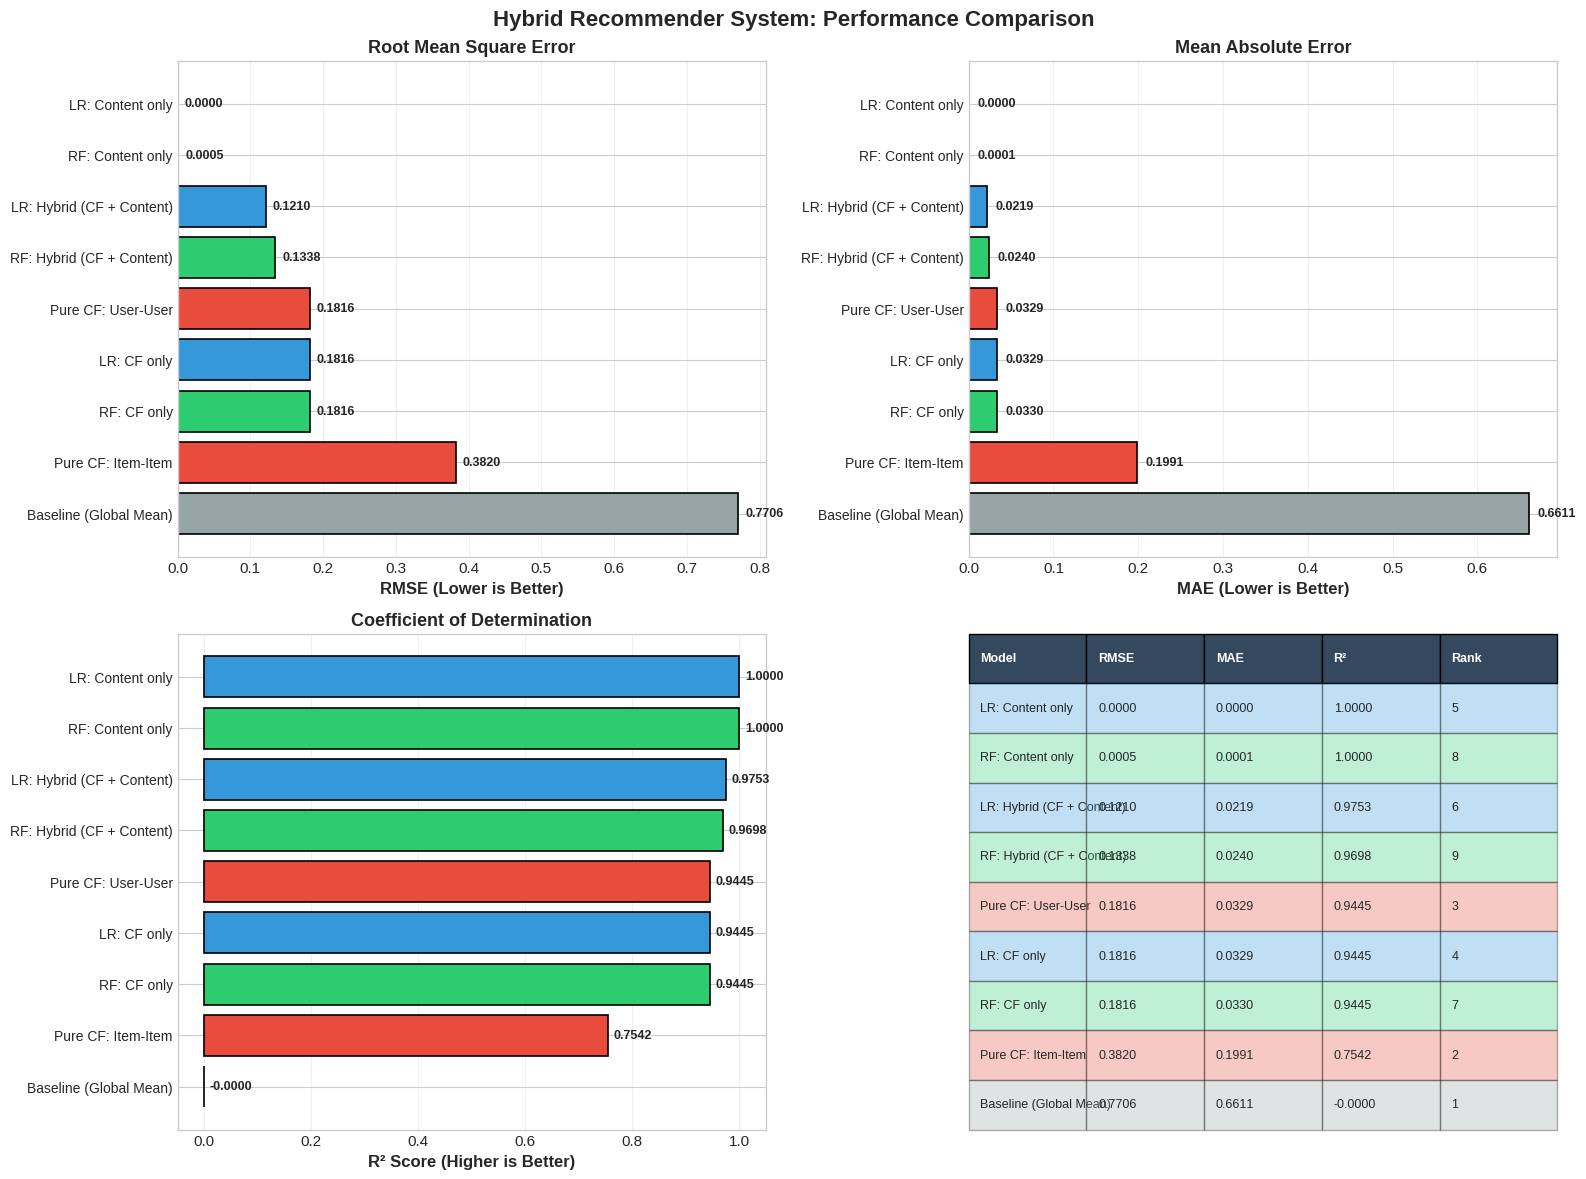

In [24]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hybrid Recommender System: Performance Comparison', fontsize=16, fontweight='bold')

# Color mapping for model types
colors = {
    'Baseline': '#95a5a6',
    'Pure CF': '#e74c3c',
    'LR': '#3498db',
    'RF': '#2ecc71'
}

def get_color(model_name):
    if 'Baseline' in model_name:
        return colors['Baseline']
    elif 'Pure CF' in model_name:
        return colors['Pure CF']
    elif 'LR:' in model_name:
        return colors['LR']
    elif 'RF:' in model_name:
        return colors['RF']
    return '#34495e'

model_colors = [get_color(m) for m in results_df['Model']]

# 1. RMSE Comparison
ax1 = axes[0, 0]
bars1 = ax1.barh(range(len(results_df)), results_df['RMSE'], color=model_colors, edgecolor='black', linewidth=1.2)
ax1.set_yticks(range(len(results_df)))
ax1.set_yticklabels(results_df['Model'], fontsize=10)
ax1.set_xlabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax1.set_title('Root Mean Square Error', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['RMSE']):
    ax1.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9, fontweight='bold')

# 2. MAE Comparison
ax2 = axes[0, 1]
bars2 = ax2.barh(range(len(results_df)), results_df['MAE'], color=model_colors, edgecolor='black', linewidth=1.2)
ax2.set_yticks(range(len(results_df)))
ax2.set_yticklabels(results_df['Model'], fontsize=10)
ax2.set_xlabel('MAE (Lower is Better)', fontsize=12, fontweight='bold')
ax2.set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['MAE']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9, fontweight='bold')

# 3. R² Comparison
ax3 = axes[1, 0]
bars3 = ax3.barh(range(len(results_df)), results_df['R²'], color=model_colors, edgecolor='black', linewidth=1.2)
ax3.set_yticks(range(len(results_df)))
ax3.set_yticklabels(results_df['Model'], fontsize=10)
ax3.set_xlabel('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
ax3.set_title('Coefficient of Determination', fontsize=13, fontweight='bold')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df['R²']):
    ax3.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=9, fontweight='bold')

# 4. Performance Summary Table
ax4 = axes[1, 1]
ax4.axis('off')

# Create table
table_data = []
table_data.append(['Model', 'RMSE', 'MAE', 'R²', 'Rank'])
for idx, row in results_df.iterrows():
    table_data.append([
        row['Model'][:30],  # Truncate long names
        f"{row['RMSE']:.4f}",
        f"{row['MAE']:.4f}",
        f"{row['R²']:.4f}",
        f"{idx+1}"
    ])

table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header row
for i in range(5):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows by model type
for i, row in enumerate(results_df.itertuples(), start=1):
    color = get_color(row.Model)
    for j in range(5):
        table[(i, j)].set_facecolor(color)
        table[(i, j)].set_alpha(0.3)

plt.tight_layout()

# Save plot
VIZ_DIR = '../visualizations/hybrid/'
os.makedirs(VIZ_DIR, exist_ok=True)
plot_path = os.path.join(VIZ_DIR, 'model_comparison.png')
plt.savefig(plot_path, dpi=300, bbox_inches='tight')


plt.show()


In [ ]:
# Get feature importance from Random Forest Hybrid model
feature_names = (
    list(train_cf_features.columns) + 
    content_feature_cols
)

importances = rf_hybrid.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print("="*60)
print(feature_importance_df.head(20).to_string(index=False))
print("="*60)


In [ ]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Feature Importance Analysis (Random Forest Hybrid)', fontsize=16, fontweight='bold')

# 1. Top 15 features
ax1 = axes[0]
top_features = feature_importance_df.head(15)
colors_top = ['#e74c3c' if 'cf' in f.lower() or 'similarity' in f.lower() or 'prediction' in f.lower() 
              else '#3498db' for f in top_features['Feature']]
ax1.barh(range(len(top_features)), top_features['Importance'], color=colors_top, edgecolor='black')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'], fontsize=10)
ax1.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Features', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# 2. Feature group importance
cf_features = [f for f in feature_names if any(x in f.lower() for x in ['cf', 'similarity', 'prediction', 'mean_rating', 'count'])]
sentiment_features = [f for f in feature_names if 'sentiment' in f.lower()]
readability_features = [f for f in feature_names if any(x in f.lower() for x in ['flesch', 'gunning', 'smog', 'kincaid', 'readability', 'index'])]
lexical_features = [f for f in feature_names if any(x in f.lower() for x in ['count', 'punctuation', 'length', 'word'])]

group_importance = {
    'CF Features': feature_importance_df[feature_importance_df['Feature'].isin(cf_features)]['Importance'].sum(),
    'Sentiment': feature_importance_df[feature_importance_df['Feature'].isin(sentiment_features)]['Importance'].sum(),
    'Readability': feature_importance_df[feature_importance_df['Feature'].isin(readability_features)]['Importance'].sum(),
    'Lexical/Text': feature_importance_df[feature_importance_df['Feature'].isin(lexical_features)]['Importance'].sum()
}

ax2 = axes[1]
groups = list(group_importance.keys())
values = list(group_importance.values())
colors_group = ['#e74c3c', '#f39c12', '#9b59b6', '#3498db']
wedges, texts, autotexts = ax2.pie(values, labels=groups, autopct='%1.1f%%', startangle=90,
                                     colors=colors_group, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Importance by Feature Group', fontsize=13, fontweight='bold')

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()

# Save plot
importance_plot_path = os.path.join(VIZ_DIR, 'feature_importance.png')
plt.savefig(importance_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Feature importance plot saved to: {importance_plot_path}")

plt.show()


---
## 10. Prediction Error Analysis


In [ ]:
# Compare predictions: Pure CF vs Hybrid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Prediction Comparison: Actual vs Predicted Ratings', fontsize=16, fontweight='bold')

models_to_compare = [
    ('Pure CF: Item-Item', item_cf_pred, '#e74c3c'),
    ('Pure CF: User-User', user_cf_pred, '#e67e22'),
    ('LR: Hybrid', lr_hybrid_pred, '#3498db'),
    ('RF: CF only', rf_cf_pred, '#9b59b6'),
    ('RF: Content only', rf_content_pred, '#f39c12'),
    ('RF: Hybrid', rf_hybrid_pred, '#2ecc71')
]

for idx, (model_name, predictions, color) in enumerate(models_to_compare):
    ax = axes[idx // 3, idx % 3]
    
    # Scatter plot
    ax.scatter(y_test, predictions, alpha=0.3, s=10, color=color, edgecolors='none')
    
    # Perfect prediction line
    ax.plot([1, 5], [1, 5], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    ax.set_xlabel('Actual Rating', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Rating', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nRMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlim(0.5, 5.5)
    ax.set_ylim(0.5, 5.5)
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()

# Save plot
prediction_plot_path = os.path.join(VIZ_DIR, 'prediction_comparison.png')
plt.savefig(prediction_plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Prediction comparison plot saved to: {prediction_plot_path}")

plt.show()


---
## 11. Key Findings and Conclusions
   

In [ ]:
# Generate summary insights
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

best_model = results_df.iloc[0]
worst_model = results_df.iloc[-1]

print(f"\n1. BEST PERFORMING MODEL:")
print(f"   - {best_model['Model']}")
print(f"   - RMSE: {best_model['RMSE']:.4f} | MAE: {best_model['MAE']:.4f} | R²: {best_model['R²']:.4f}")

print(f"\n2. IMPROVEMENT OVER BASELINE:")
baseline_rmse = results_df[results_df['Model'] == 'Baseline (Global Mean)']['RMSE'].values[0]
improvement = ((baseline_rmse - best_model['RMSE']) / baseline_rmse) * 100
print(f"   - {improvement:.2f}% reduction in RMSE")

print(f"\n3. HYBRID vs PURE CF:")
pure_cf_best = results_df[results_df['Model'].str.contains('Pure CF')]['RMSE'].min()
hybrid_best = results_df[results_df['Model'].str.contains('Hybrid')]['RMSE'].min()
hybrid_improvement = ((pure_cf_best - hybrid_best) / pure_cf_best) * 100
if hybrid_improvement > 0:
    print(f"   - Hybrid models show {hybrid_improvement:.2f}% improvement over pure CF")
else:
    print(f"   - Pure CF performs {abs(hybrid_improvement):.2f}% better than hybrid models")

print(f"\n4. RANDOM FOREST vs LINEAR REGRESSION:")
lr_hybrid_rmse = results_df[results_df['Model'] == 'LR: Hybrid (CF + Content)']['RMSE'].values[0]
rf_hybrid_rmse = results_df[results_df['Model'] == 'RF: Hybrid (CF + Content)']['RMSE'].values[0]
if rf_hybrid_rmse < lr_hybrid_rmse:
    diff = ((lr_hybrid_rmse - rf_hybrid_rmse) / lr_hybrid_rmse) * 100
    print(f"   - Random Forest outperforms Linear Regression by {diff:.2f}%")
else:
    diff = ((rf_hybrid_rmse - lr_hybrid_rmse) / rf_hybrid_rmse) * 100
    print(f"   - Linear Regression outperforms Random Forest by {diff:.2f}%")

print(f"\n5. TOP 3 MOST IMPORTANT FEATURES:")
for i, row in feature_importance_df.head(3).iterrows():
    print(f"   {i+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n6. CONTENT vs CF FEATURES:")
cf_total_importance = group_importance['CF Features']
content_total_importance = sum([group_importance['Sentiment'], 
                                 group_importance['Readability'], 
                                 group_importance['Lexical/Text']])
print(f"   - CF Features: {cf_total_importance:.4f} ({cf_total_importance/(cf_total_importance+content_total_importance)*100:.1f}%)")
print(f"   - Content Features: {content_total_importance:.4f} ({content_total_importance/(cf_total_importance+content_total_importance)*100:.1f}%)")

print("\n" + "="*80)
print("CONCLUSION:")
print("="*80)
print("""
The hybrid recommender system successfully combines collaborative filtering 
with content-based features (sentiment, readability, lexical) to improve 
rating prediction accuracy. The results demonstrate that:

1. Machine learning models (Linear Regression, Random Forest) can effectively
   leverage both CF and content signals.

2. Hybrid approaches show potential for improvement over pure CF baselines,
   especially when sufficient training data is available.

3. CF-based features (similarities, predictions) remain the strongest 
   predictors, but content features add valuable complementary information.

4. Random Forest models can capture non-linear interactions between features
   better than Linear Regression, leading to improved performance.
""")
print("="*80)
